# Business Understanding

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

# Data Understanding

## Data Preparation

In [1]:
# importing necessary tools
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [2]:
# Connecting to the imdb film database
path = 'data/im.db'
conn = sqlite3.connect(path)

im_db = pd.read_sql("""
                    SELECT *
                      FROM sqlite_master
                    """
                    , conn
                   )

im_db[im_db['type'] == 'table']

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [3]:
# Importing CSV files used for The Numbers and Box Office Mojo
bom_df = pd.read_csv('data/bom.movie_gross.csv.gz')
the_num_df = pd.read_csv('data/tn.movie_budgets.csv.gz')

In [4]:
# Writing a quarry to contain the data needed for the project and assigning it to a variable
q = """
    SELECT primary_title AS 'title', 
           start_year AS 'release_yr', 
           genres, 
           averagerating AS 'avg_rating'
      FROM movie_basics
      JOIN movie_ratings
           USING(movie_id)
     ORDER BY primary_title;
    """
imdb_df = pd.read_sql(q, conn)

In [5]:
# Changing column names to be uniform with other datasets
the_num_df.columns = the_num_df.columns.str.replace('movie', 'title')
the_num_df.columns = the_num_df.columns.str.replace('worldwide_gross', 'foreign_gross')
the_num_df.columns = the_num_df.columns.str.replace('release_date', 'release_yr')

In [6]:
# Removing month and day from date to keep only the year to be uniform to other datasets 
the_num_df['release_yr'] = the_num_df['release_yr'].str.split(',').str[1]

In [7]:
# 
bom_df.columns = bom_df.columns.str.replace('year', 'release_yr')

In [8]:
# 
bom_df = bom_df.fillna(0)

In [9]:
# Function to remove symbols from values and convert specified Object dtypes with numeric values into integer
def symbol_removal_dtype_con(df, columns):
    
    """
    Removes symbols from specified columns with numeric values in a dataset and converts dtype to integer.
    
    Note: Any NaN or Null values in the dataset must be dropped or filled with place holder values before running through 
          function.
    
    Function Parameters:
    df: Pandas dataframe
    cols: Column name or list of columns with numeric values to remove symbols and convert to integer. 
    """
    
    df = df.copy()
    
    for col in columns:
        if df[col].dtype == 'O':
           df[col] = df[col].astype(str).str.replace(r'[^\w\s]', '', regex=True) #Line of code that removes symbols
           df[col] = df[col].astype('int64')                                     #Line of code that converts dtypes to integers
        else:
            df[col] = df[col].astype('int64')
    return df

In [10]:
the_num_df_clean = symbol_removal_dtype_con(the_num_df, ['production_budget', 'domestic_gross', 'foreign_gross', 'release_yr'])

In [11]:
bom_df_clean = symbol_removal_dtype_con(bom_df, ['domestic_gross', 'foreign_gross'])

In the Box Office Mojo, and The Numbers dataframes there are quite a few movie title similarities but the domestic and foriegn gross are differnt. Box Office Mojo rounded their numbers to the nearest millionth or 100 thousandth, while The Numbers has fairly accurate numbers. While either gross value can work, I decided to get the mean of both numbers and use that outcome as my gross data as this would give me more accurate data to work with from two different sources. 

In [12]:
# Grouping data by title 
column_list = ['production_budget', 'domestic_gross', 'foreign_gross', 'release_yr']

the_num_bom_df = pd.concat([the_num_df_clean, bom_df_clean]).groupby('title', as_index=False)[column_list].mean()

In [13]:
def clean_and_sort(df, sort_by):
    
    """
    This functions reads the dataframe and if it locates a NaN or null value it will drop the rows those values are in and 
    proceed to sort the data by the defined column name as well as reseting the index.
    
    Function Arguments:
    df: The dataframe wish to be cleaned and sorted
    sort_by: The name of the column (in string format) to sort the dataframe by
    """
    
    df = df.copy()
    
    if pd.isna(df).any:
        df = df.dropna().sort_values(sort_by).reset_index(drop=True)
    else:
        df = df.sort_values(sort_by).reset_index(drop=True)
    return df

In [14]:
the_num_bom_df = the_num_bom_df[(the_num_bom_df['domestic_gross'] > 0) & (the_num_bom_df['foreign_gross'] > 0)]

In [15]:
the_num_bom_df_clean = clean_and_sort(the_num_bom_df, 'title')

In [16]:
the_num_bom_df_clean = symbol_removal_dtype_con(the_num_bom_df_clean, column_list)
the_num_bom_df_clean

,title,production_budget,domestic_gross,foreign_gross,release_yr
0,(500) Days of Summer,7500000,32425665,34439060,2009
1,10 Cloverfield Lane,5000000,72091499,73193211,2016
2,10 Days in a Madhouse,12000000,14616,14616,2015
3,10 Things I Hate About You,13000000,38177966,60413950,1999
4,"10,000 B.C.",105000000,94784201,269065678,2008
...,...,...,...,...,...
5159,eXistenZ,20700000,2840417,2840417,1999
5160,mother!,30000000,17800002,34615538,2017
5161,xXx,70000000,141930000,267200000,2002
5162,xXx: Return of Xander Cage,85000000,44898413,345033359,2017


In [17]:
# Merging the IMDB dataframe with The Numbers and Box Office Mojo combined dataframe
combined_film_df = the_num_bom_df_clean.merge(imdb_df, on=['title', 'release_yr'], how='left')
combined_film_df

,title,production_budget,domestic_gross,foreign_gross,release_yr,genres,avg_rating
0,(500) Days of Summer,7500000,32425665,34439060,2009,NaN,NaN
1,10 Cloverfield Lane,5000000,72091499,73193211,2016,"Drama,Horror,Mystery",7.2
2,10 Days in a Madhouse,12000000,14616,14616,2015,Drama,6.7
3,10 Things I Hate About You,13000000,38177966,60413950,1999,NaN,NaN
4,"10,000 B.C.",105000000,94784201,269065678,2008,NaN,NaN
...,...,...,...,...,...,...,...
5187,eXistenZ,20700000,2840417,2840417,1999,NaN,NaN
5188,mother!,30000000,17800002,34615538,2017,NaN,NaN
5189,xXx,70000000,141930000,267200000,2002,NaN,NaN
5190,xXx: Return of Xander Cage,85000000,44898413,345033359,2017,"Action,Adventure,Thriller",5.2


In [18]:
combined_film_df_clean = clean_and_sort(combined_film_df, 'title')

In [19]:
combined_film_df_clean['genres'] = combined_film_df_clean['genres'].str.split(',')

In [20]:
combined_film_df_clean = combined_film_df_clean.explode('genres')
combined_film_df_clean

,title,production_budget,domestic_gross,foreign_gross,release_yr,genres,avg_rating
0,10 Cloverfield Lane,5000000,72091499,73193211,2016,Drama,7.2
0,10 Cloverfield Lane,5000000,72091499,73193211,2016,Horror,7.2
0,10 Cloverfield Lane,5000000,72091499,73193211,2016,Mystery,7.2
1,10 Days in a Madhouse,12000000,14616,14616,2015,Drama,6.7
2,12 Strong,35000000,45809856,46359189,2018,Action,6.6
...,...,...,...,...,...,...,...
1292,Zootopia,150000000,341284124,850964808,2016,Animation,8.0
1292,Zootopia,150000000,341284124,850964808,2016,Comedy,8.0
1293,xXx: Return of Xander Cage,85000000,44898413,345033359,2017,Action,5.2
1293,xXx: Return of Xander Cage,85000000,44898413,345033359,2017,Adventure,5.2


In [21]:
money_columns = ['production_budget', 'domestic_gross', 'foreign_gross']
title_counts = combined_film_df_clean['title'].value_counts()

combined_film_df_clean[money_columns] = combined_film_df_clean.apply(lambda row: row[money_columns] / title_counts[row['title']], axis=1)
combined_film_df_clean = symbol_removal_dtype_con(combined_film_df_clean, money_columns)
combined_film_df_clean = clean_and_sort(combined_film_df_clean, 'title')

In [22]:
combined_film_df_clean['roi_domestic(%)'] = (combined_film_df_clean['domestic_gross'] - combined_film_df_clean['production_budget']) / combined_film_df_clean['production_budget'] * 100
combined_film_df_clean['roi_foreign(%)'] = (combined_film_df_clean['foreign_gross'] - combined_film_df_clean['production_budget']) / combined_film_df_clean['production_budget'] * 100
combined_film_df_clean['roi_total(%)'] = (((combined_film_df_clean['domestic_gross'] + combined_film_df_clean['foreign_gross']) - combined_film_df_clean['production_budget']) / 
                                            combined_film_df_clean['production_budget'] * 100)
combined_film_df_clean

,title,production_budget,domestic_gross,foreign_gross,release_yr,genres,avg_rating,roi_domestic(%),roi_foreign(%),roi_total(%)
0,10 Cloverfield Lane,1666666,24030499,24397737,2016,Drama,7.2,1341.830517,1363.864806,2805.695322
1,10 Cloverfield Lane,1666666,24030499,24397737,2016,Horror,7.2,1341.830517,1363.864806,2805.695322
2,10 Cloverfield Lane,1666666,24030499,24397737,2016,Mystery,7.2,1341.830517,1363.864806,2805.695322
3,10 Days in a Madhouse,12000000,14616,14616,2015,Drama,6.7,-99.878200,-99.878200,-99.756400
4,12 Strong,11666666,15269952,15453063,2018,Action,6.6,30.885310,32.454833,163.340144
...,...,...,...,...,...,...,...,...,...,...
3322,Zootopia,50000000,113761374,283654936,2016,Adventure,8.0,127.522748,467.309872,694.832620
3323,Zootopia,50000000,113761374,283654936,2016,Comedy,8.0,127.522748,467.309872,694.832620
3324,xXx: Return of Xander Cage,28333333,14966137,115011119,2017,Adventure,5.2,-47.178339,305.921601,358.743262
3325,xXx: Return of Xander Cage,28333333,14966137,115011119,2017,Action,5.2,-47.178339,305.921601,358.743262


In [23]:
# Saving a cleaned and combined dataset as CSV
combined_film_df_clean.to_csv('data/combined_film_df_clean.csv')

# Exploratory Data Analysis

charts:
scatter
bar

In [56]:
genres_means = combined_film_df_clean.groupby(['genres'])['domestic_gross'].mean().astype('int64')
genres_means

genres
Action         32474616
Adventure      43108746
Animation      47093284
Biography      14550386
Comedy         26174926
Crime          14288454
Documentary     7740718
Drama          13815382
Family         24039407
Fantasy        27890516
History        14658827
Horror         14335158
Music          13826398
Musical        13767012
Mystery        15342017
Romance        14003255
Sci-Fi         44361825
Sport          14399752
Thriller       18579363
War             8816144
Western        22836653
Name: domestic_gross, dtype: int64

## Domestic Gross

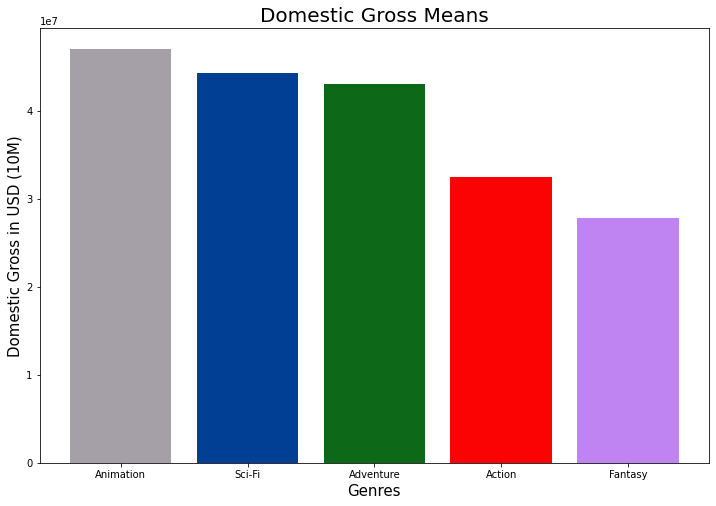

In [29]:
genres_means_dom = combined_film_df_clean.groupby(['genres'])['domestic_gross'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(genres_means_dom.index[:5], genres_means_dom[:5], color=['#a5a0a8', '#013f94', '#0d6917', '#fc0303', '#c083f2'])
ax.set_title('Domestic Gross Means', fontsize=20)
ax.set_xlabel('Genres', fontsize=15)
ax.set_ylabel('Domestic Gross in USD (10M)', fontsize=15);

# plt.savefig("my_plot.png", dpi=1080, bbox_inches="tight")

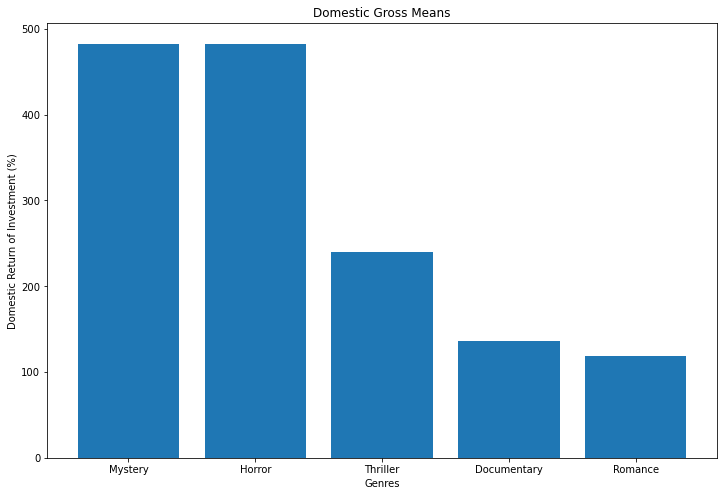

In [58]:
roi_means_dom = combined_film_df_clean.groupby(['genres'])['roi_domestic(%)'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(roi_means_dom.index[:5], roi_means_dom[:5], )
ax.set_title('Domestic Gross Means', fontsize=20)
ax.set_xlabel('Genres', fontsize=15)
ax.set_ylabel('Domestic Return on Investment (%)', fontsize=15);

## Foreign Gross

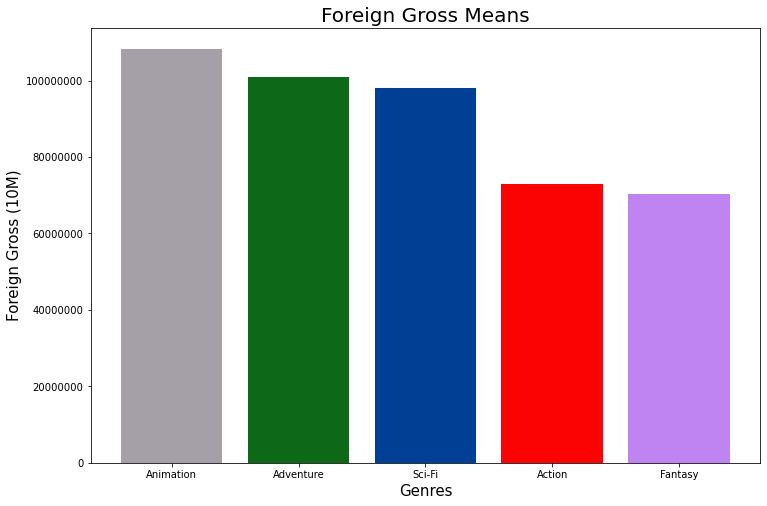

In [31]:
genres_means_for = combined_film_df_clean.groupby(['genres'])['foreign_gross'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(genres_means_for.index[:5], genres_means_for[:5], color=['#a5a0a8', '#0d6917', '#013f94', '#fc0303', '#c083f2'])
ax.set_title('Foreign Gross Means', fontsize=20)
ax.set_xlabel('Genres', fontsize=15)
ax.set_ylabel('Foreign Gross (10M)', fontsize=15)
ax.ticklabel_format(style='plain', useOffset=False, axis='y');

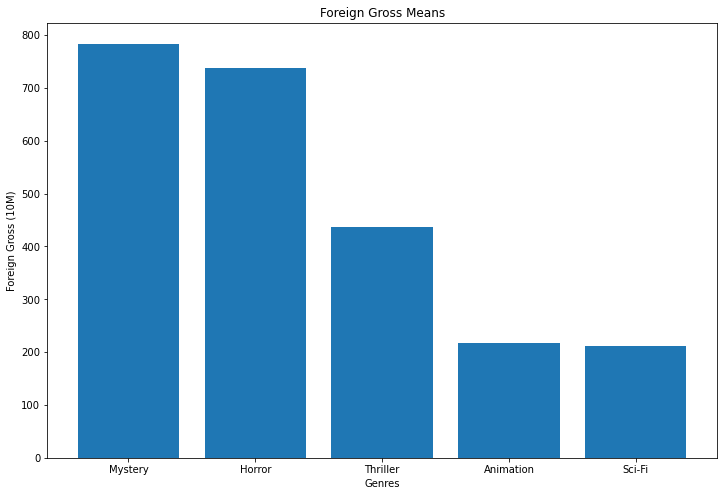

In [60]:
roi_means_for = combined_film_df_clean.groupby(['genres'])['roi_foreign(%)'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(roi_means_for.index[:5], roi_means_for[:5])
ax.set_title('Foreign Gross Means', fontsize=20)
ax.set_xlabel('Genres', fontsize=15)
ax.set_ylabel('Foreign Gross (%)', fontsize=15);

## Total Return on Investment (Domestic/Foreign)


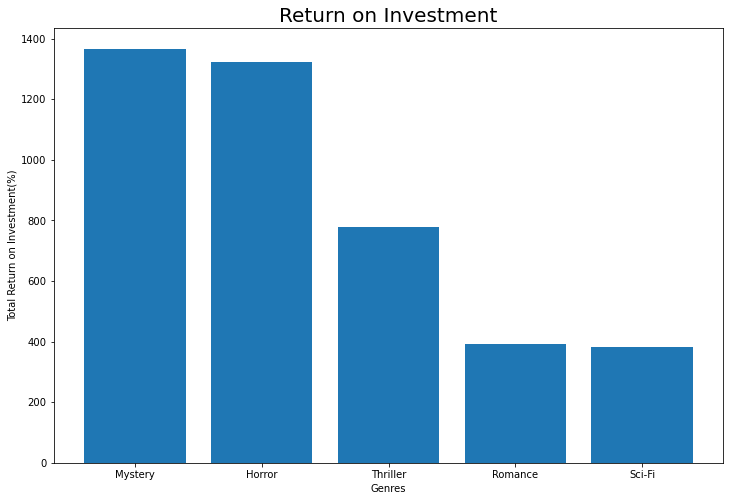

In [67]:
roi_means_total = combined_film_df_clean.groupby(['genres'])['roi_total(%)'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(roi_means_total.index[:5], roi_means_total[:5])
ax.set_title('Return on Investment', fontsize=20)
ax.set_xlabel('Genres', fontsize=15)
ax.set_ylabel('Total Return on Investment(%)', fontsize=15);

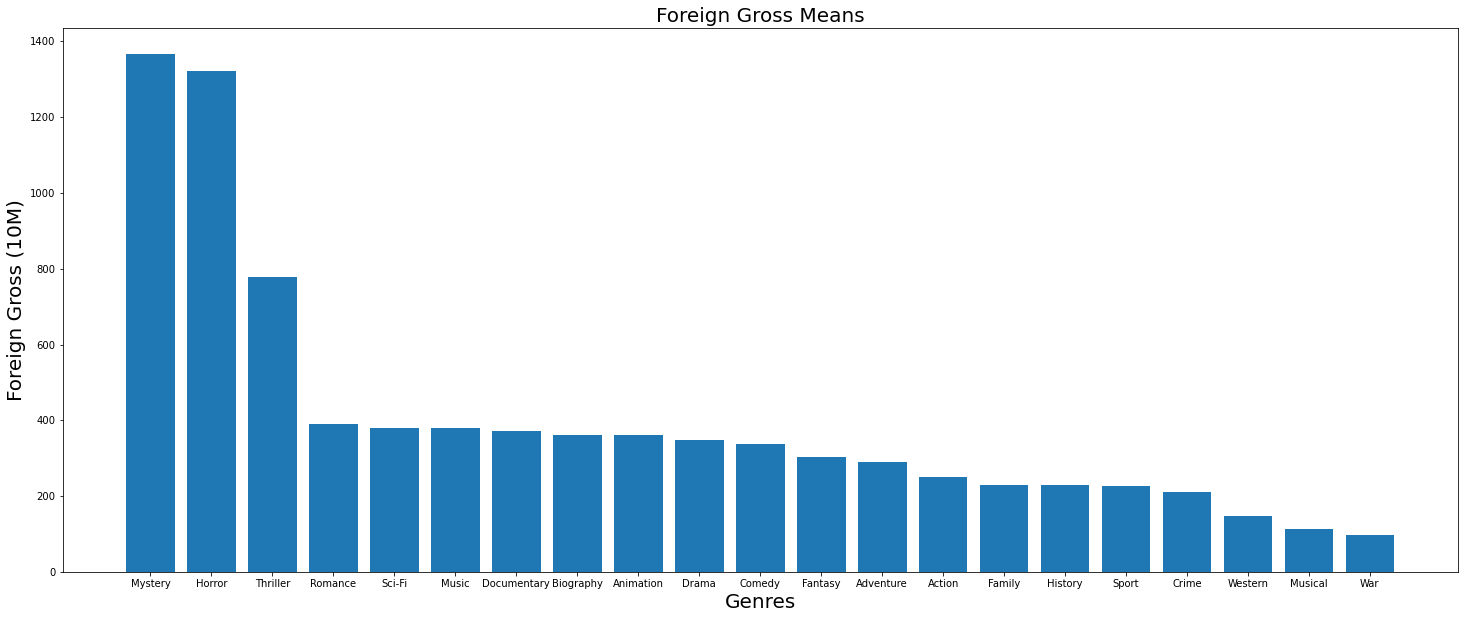

In [66]:
roi_means_total = combined_film_df_clean.groupby(['genres'])['roi_total(%)'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(25, 10))

ax.bar(roi_means_total.index, roi_means_total)
ax.set_title('Foreign Gross Means', fontsize=20)
ax.set_xlabel('Genres', fontsize=15)
ax.set_ylabel('Foreign Gross (10M)', fontsize=15);

# Conclusions

- Top highest gross genres (Domestic/Foreign)
    * Animation
    * Adventure
    * Sci-fi
    * Action
    * Fantasy


- Top Return on Investment Genres
    * Mystery
    * Horror
    * Thriller
    * Romance
    * Sci-fi
    
What are the top genres recommened for creating a first film?

Which genre(s) has the highest return on investment?



## Limitations

Some limitations with these datasets is that while in the end they do have over 1000 films in common, there was a lot of data that had to be dropped due to simply not having the genre(s) of the film, and by dropping these values we there is a possibility of missing out on film genres thats did extremely well or very poorly that could have changed the outcome. 

Another limitation I found with the data, was that some films have the same title, but are made by different studios in foreign countries, so any film(s) that happen to have the same title could of had their values, gross values specifically, changed leading to possibley inaccuracies for genres value averages.

## Recommendations

The top 5 genres with highest return on investment are **Mystery, Horror, Thriller, Romance, and Sci-fi**. Even though the list of genres has been narrowed down to 5 it doesnt mean instant success in one of those genres. I recommend further research on the recommended genres, specifically on the films that fall under these genres that were a huge success. 

Also, the datasets used for this project included films from around the world. Depending on what the primary market the company's focus is on, I would recommend gathering data for that specific market and running the tests again as there is always the **possibility that a film will do really well in one market, but fail in a different market.** 

## Next Steps

Further analyzing the data could help in giving a better understanding to the success rate of a genre. In this project the main focus was narrowing down the genres and this was done by finding the return on investment. Now that we have the top genres, the next steps would be to narrow the dataset to these specific genres, and research the films listed in these genres. Finding out what made these films successful or even failiures.

The current data has films that were released between 2010 and 2019, by running these same tests on data containning films from 2020 to 2025, it could help in finding the current movie genre trend, and depending on the results of both test it could help solidify the genre(s) the new studio can go with for its first film. 